In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [2]:
import matplotlib

COLOR = 'white'
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

In [3]:
import torch


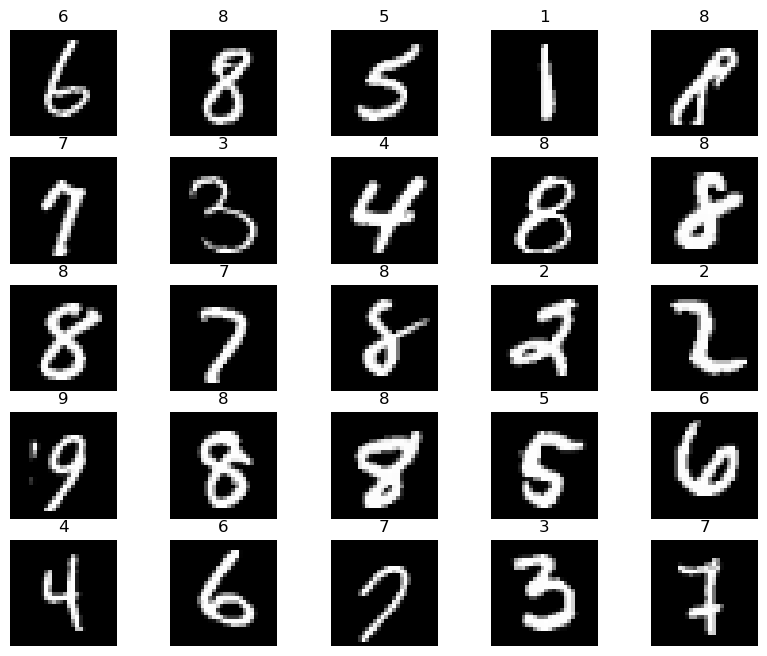

In [4]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [5]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x171d7608760>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x171d7608700>}

In [6]:
print(test_data[1][0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.4549, 0.4902, 0.6706, 1.0000, 1.0000, 0.5882,
          0.3647, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [7]:
x_test=[]
for x in range(len(test_data)):
    x_test+=[test_data[x][0]]

In [21]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [22]:
cnn = CNN().to('cuda')
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [23]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [24]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [25]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
train(num_epochs, cnn, loaders)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
import time

cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    t=[]
    for images, labels in loaders['test']:
        s=time.time()
        test_output, last_layer = cnn(images)
        e=time.time()
        t+=[e-s]
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))            
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

In [14]:
torch.save(cnn,"model.pt")

<BarContainer object of 100 artists>

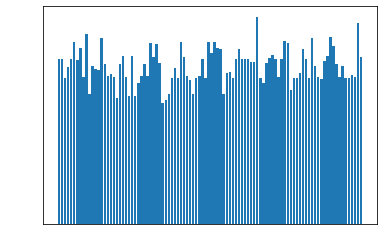

In [15]:
plt.bar(range(len(t)),t)

In [16]:
#Post Training Dynamic Quantization

In [17]:
model_int8 = torch.quantization.quantize_dynamic(
    CNN(),  # the original model
    {torch.nn.Linear,torch.nn.Conv2d, torch.nn.MaxPool2d},  # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

# run the model
#res = model_int8(x_test)
t1=[]
for images, labels in loaders['test']:
        s=time.time()
        model_int8(images)
        e=time.time()
        t1+=[e-s]

In [18]:
torch.save(model_int8, "model1.pt")

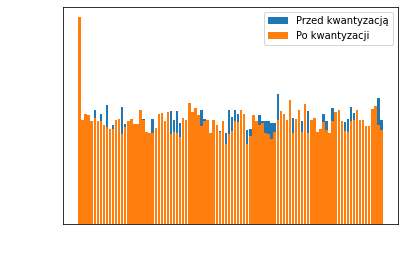

In [19]:
plt.bar(range(1,len(t)+1),t)
plt.bar(range(1,len(t1)+1),t1)
plt.xlabel("Numery próbek")
plt.ylabel("Czas w [s]")
plt.legend(["Przed kwantyzacją","Po kwantyzacji"])

In [20]:
#Post Training Static Quantization

In [21]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.conv = nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            )                              
        self.relu=nn.ReLU()
        self.max=nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.relu2=nn.ReLU()    
        self.max2=nn.MaxPool2d(2)
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.conv(x)
        x = self.relu(x)        
        x = self.max(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.reshape(156800)    
        
        x = self.dequant(x)
        return x
        

In [22]:
# create a model instance
model_fp32 = CNN()

# model must be set to eval mode for static quantization logic to work
model_fp32.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'fbgemm' for server inference and
# 'qnnpack' for mobile inference. Other quantization configurations such
# as selecting symmetric or assymetric quantization and MinMax or L2Norm
# calibration techniques can be specified here.
model_fp32.qconfig = torch.quantization.get_default_qconfig('fbgemm')

# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
model_fp32_fused = torch.quantization.fuse_modules(model_fp32, [['conv', 'relu']])

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_prepared = torch.quantization.prepare(model_fp32_fused)

# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_int8 = torch.quantization.convert(model_fp32_prepared)

# run the model, relevant calculations will happen in int8

C:\Users\adamz\miniconda3\lib\site-packages\torch\ao\quantization\observer.py:176: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
C:\Users\adamz\miniconda3\lib\site-packages\torch\ao\quantization\observer.py:1135: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [23]:
t2=[]
for images, labels in loaders['test']:
        s=time.time()
        pred2=model_int8(images)
        e=time.time()
        t2+=[e-s]        

In [24]:
torch.save(model_int8, "model2.pt")

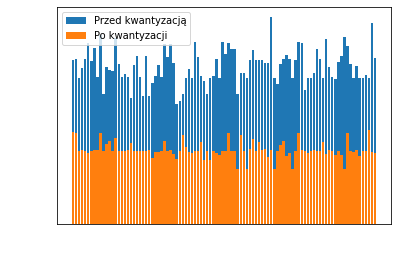

In [25]:
plt.bar(range(1,len(t)+1),t)
plt.bar(range(1,len(t2)+1),t2)
plt.xlabel("Numery próbek")
plt.ylabel("Czas w [s]")
plt.legend(["Przed kwantyzacją","Po kwantyzacji"])

In [26]:
#Quantization Aware Training for Static Quantization

In [27]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.conv = nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            )                              
        self.relu=nn.ReLU()
        self.max=nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.relu2=nn.ReLU()    
        self.max2=nn.MaxPool2d(2)
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.conv(x)
        x = self.relu(x)        
        x = self.max(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.reshape(156800)    
        
        x = self.dequant(x)
        return x
        

In [28]:
# create a model instance
model_fp32 = CNN()

# model must be set to train mode for QAT logic to work
model_fp32.train()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'fbgemm' for server inference and
# 'qnnpack' for mobile inference. Other quantization configurations such
# as selecting symmetric or assymetric quantization and MinMax or L2Norm
# calibration techniques can be specified here.
model_fp32.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

# fuse the activations to preceding layers, where applicable
# this needs to be done manually depending on the model architecture
model_fp32_fused = torch.quantization.fuse_modules(model_fp32,
    [['conv', 'relu']])

# Prepare the model for QAT. This inserts observers and fake_quants in
# the model that will observe weight and activation tensors during calibration.
model_fp32_prepared = torch.quantization.prepare_qat(model_fp32_fused)

# run the training loop (not shown)
#training_loop(model_fp32_prepared)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, fuses modules where appropriate,
# and replaces key operators with quantized implementations.
model_fp32_prepared.eval()
model_int8 = torch.quantization.convert(model_fp32_prepared)

# run the model, relevant calculations will happen in int8


C:\Users\adamz\miniconda3\lib\site-packages\torch\ao\quantization\utils.py:280: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


In [29]:
t3=[]
for images, labels in loaders['test']:
        s=time.time()
        model_int8(images)
        e=time.time()
        t3+=[e-s]


In [30]:
torch.save(model_int8, "model3.pt")

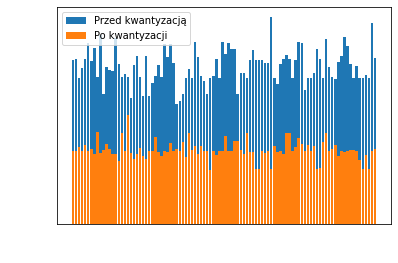

In [31]:
plt.bar(range(1,len(t)+1),t)
plt.bar(range(1,len(t3)+1),t3)
plt.xlabel("Numery próbek")
plt.ylabel("Czas w [s]")
plt.legend(["Przed kwantyzacją","Po kwantyzacji"])

In [32]:
import numpy as np
print(np.std(t))
print(np.std(t1))
print(np.std(t2))
print(np.std(t3))

0.0009309038841693135
0.0012032540503089167
0.0004254671057272447
0.000494822004572136


In [33]:
print(np.mean(t))
print(np.mean(t1))
print(np.mean(t2))
print(np.mean(t3))

0.008653256893157959
0.008949382305145264
0.004067084789276123
0.00405799150466919


In [34]:
print(np.median(t))
print(np.median(t1))
print(np.median(t2))
print(np.median(t3))

0.008686184883117676
0.008999109268188477
0.00400090217590332
0.004001140594482422


In [35]:
print(np.var(t))
print(np.var(t1))
print(np.var(t2))
print(np.var(t3))

8.665820415615145e-07
1.447820309584813e-06
1.810222580559184e-07
2.4484881620878697e-07


In [36]:
sr2=[]
sr3=[]
sr4=[]
for i in range(len(t)):
    sr2+=[t[i]/t1[i]]
    sr3+=[t[i]/t2[i]]
    sr4+=[t[i]/t3[i]]

In [37]:
print(np.mean(sr2))
print(np.mean(sr3))
print(np.mean(sr4))

0.9807738055151073
2.146234862644516
2.1672561010935047


In [38]:
x = torch.randn(1, 1, 28, 28, requires_grad=True)

torch.onnx.export(cnn,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [39]:
import onnx

onnx_model = onnx.load("super_resolution.onnx")

In [41]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("super_resolution.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {"input": to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)


In [42]:
t5=[]
for images, labels in loaders['test']:
        ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(images)}
        s=time.time()
        ort_outs = ort_session.run(None, ort_inputs)
        e=time.time()
        t5+=[e-s]

In [43]:
print(np.var(t5))

1.7535162780859535e-07


In [44]:
sr2=[]
sr3=[]
sr4=[]
sr5=[]
for i in range(len(t)):
    sr2+=[t[i]/t1[i]]
    sr3+=[t[i]/t2[i]]
    sr4+=[t[i]/t3[i]]
    sr5+=[t[i]/t5[i]]

In [45]:
print(np.mean(sr5))

4.684239242404428
